In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from nltk.stem.porter import *

from nltk import sent_tokenize, word_tokenize 

es = EarlyStopping(monitor="val_loss", mode="min", patience=5)
EPOCHS = 50


2024-01-31 17:48:13.034643: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-31 17:48:13.128382: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 17:48:18.764081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df=pd.read_csv('Twitter_Data.csv')
df.duplicated().sum()

df = df[['clean_text','category']]


In [3]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [4]:
label_mapping = {-1: 0, 0: 1, 1: 2}
df['category'] = df['category'].map(label_mapping)

In [5]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,0.0
1,talk all the nonsense and continue all the dra...,1.0
2,what did just say vote for modi welcome bjp t...,2.0
3,asking his supporters prefix chowkidar their n...,2.0
4,answer who among these the most powerful world...,2.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,0.0
162976,dear rss terrorist payal gawar what about modi...,0.0
162977,did you cover her interaction forum where she ...,1.0
162978,there big project came into india modi dream p...,1.0


In [6]:
df = df[df['category'].isin([0, 1, 2])]

In [7]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,0.0
1,talk all the nonsense and continue all the dra...,1.0
2,what did just say vote for modi welcome bjp t...,2.0
3,asking his supporters prefix chowkidar their n...,2.0
4,answer who among these the most powerful world...,2.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,0.0
162976,dear rss terrorist payal gawar what about modi...,0.0
162977,did you cover her interaction forum where she ...,1.0
162978,there big project came into india modi dream p...,1.0


In [8]:
import pandas as pd

# Step 1: Load the dataset
#file_path = 'Twitter_Data.csv'  # Update with the correct path to your dataset
#data = pd.read_csv(file_path)

# Step 2: Select the first five rows of 'clean_text' and 'category' columns
selected_data = df[['clean_text', 'category']].head(50)

# Step 3: Display the data
print(selected_data)

# Step 4: Save the table to an HTML file
html_file_path = 'selected_data_table.html'  # Update with desired file path
selected_data.to_html(html_file_path, index=False)

print(f"Table saved to {html_file_path}")


                                           clean_text  category
0   when modi promised “minimum government maximum...       0.0
1   talk all the nonsense and continue all the dra...       1.0
2   what did just say vote for modi  welcome bjp t...       2.0
3   asking his supporters prefix chowkidar their n...       2.0
4   answer who among these the most powerful world...       2.0
5            kiya tho refresh maarkefir comment karo        1.0
6   surat women perform yagna seeks divine grace f...       1.0
7   this comes from cabinet which has scholars lik...       1.0
8   with upcoming election india saga going import...       2.0
9                          gandhi was gay does modi         2.0
10  things like demonetisation gst goods and servi...       2.0
11  hope tuthukudi people would prefer honest well...       2.0
12                  calm waters wheres the modi wave        2.0
13  one vote can make all the difference anil kapo...       1.0
14  one vote can make all the difference

In [9]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

'''dodatkowe importy'''
from tqdm import tqdm 

[nltk_data] Downloading package stopwords to /home/jupyter-
[nltk_data]     tomesew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter-
[nltk_data]     tomesew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter-
[nltk_data]     tomesew/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter-
[nltk_data]     tomesew/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
re_puncs = re.compile('[%s]' % re.escape(string.punctuation))
re_puncs

re.compile(r'[!"\#\$%\&\'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}\~]',
           re.UNICODE)

In [11]:
# Storing all stop words like a, an, the, when, there, this etc
stop_word  = set(stopwords.words('english'))
stop_word
stop_word.add("nt")



In [12]:
main = []
lem = WordNetLemmatizer()
p_stem = PorterStemmer()

# Traversing whole dataset
for i in tqdm(range(len(df.clean_text))):
    text = str(df.iloc[i,0]) 
    tokens = word_tokenize(str(text))
    tokens = [w.lower() for w in tokens]
    tokens = [re_puncs.sub('', w) for w in tokens]
    tokens = [i for i in tokens if i.isalpha()]   
    tokens = [w for w in tokens if w not in stop_word]
    tokens = [lem.lemmatize(w) for w in tokens]
    tokens = [p_stem.stem(w) for w in tokens]
    r = ' '.join(tokens)
    main.append(r)
                 
df['new']=main

100%|██████████| 162973/162973 [06:12<00:00, 437.30it/s] 
/tmp/ipykernel_2986402/145291659.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new']=main


In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#numwords - ile różnych znaków będie analizowanych - słownik tokenów
#oov_token - jak oznaczyć słowa które są w tekście ale nieuwzględnione w słowniku tokenów
tokenizer = Tokenizer(num_words = 10000, oov_token = "<00V>")
tokenizer.fit_on_texts(df['new'])

In [14]:
config = tokenizer.get_config()
print(len(tokenizer.word_counts))

81435


In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(df["new"], df['category'], train_size = 0.8, random_state=1)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train, maxlen=50, padding="post")
X_test_pad = pad_sequences(X_test, maxlen=50, padding="post")

In [16]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
es = EarlyStopping(monitor="val_loss", mode="min", patience=5)
EPOCHS = 100

In [29]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=4, input_length=50),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation = 'relu'),
    Dense(3, activation='softmax')
])

model.summary()
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), callbacks=es, epochs=EPOCHS)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 4)             40000     
                                                                 
 flatten_4 (Flatten)         (None, 200)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                12864     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 3)                 99        
                                                                 
Total params: 55043 (215.01 KB)
Trainable params: 55043 (215.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4075

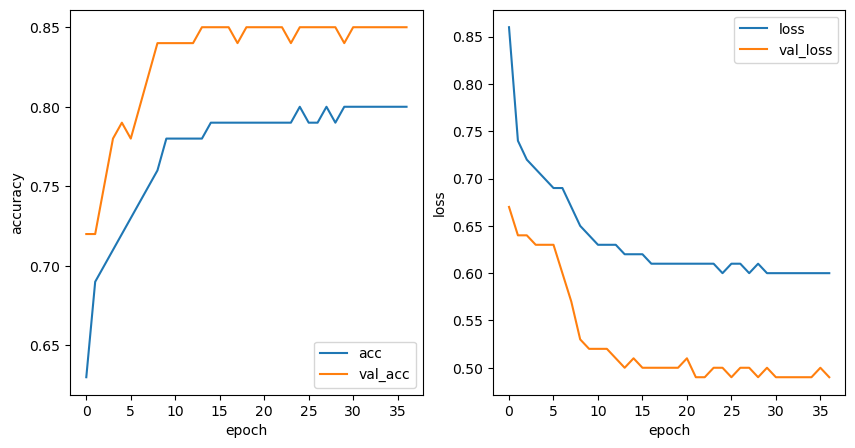

In [48]:

hist = pd.DataFrame(h.history).round(2)
plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.plot(hist.loss, label = "loss")
plt.plot(hist.val_loss, label = "val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,2,1)
plt.plot(hist.accuracy, label = "acc")
plt.plot(hist.val_accuracy, label = "val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.savefig('model1')

In [32]:
modelm = Sequential([
    Embedding(input_dim=10000, output_dim=4, input_length=50),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation = 'relu'),
    Dense(3, activation='softmax')
])

modelm.summary()
modelm.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 4)             40000     
                                                                 
 flatten_5 (Flatten)         (None, 200)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               25728     
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 3)                 99        
                                                                 
Total params: 76163 (297.51 KB)
Trainable params: 7616

In [33]:
hm = modelm.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), callbacks=es, epochs=EPOCHS)
histm = pd.DataFrame(hm.history).round(2)

Epoch 1/100
4075/4075 [==============================] - 10s 2ms/step - loss: 0.5388 - accuracy: 0.7869 - val_loss: 0.4158 - val_accuracy: 0.8523
Epoch 2/100
4075/4075 [==============================] - 9s 2ms/step - loss: 0.3825 - accuracy: 0.8640 - val_loss: 0.4054 - val_accuracy: 0.8583
Epoch 3/100
4075/4075 [==============================] - 9s 2ms/step - loss: 0.3491 - accuracy: 0.8775 - val_loss: 0.4087 - val_accuracy: 0.8584
Epoch 4/100
4075/4075 [==============================] - 8s 2ms/step - loss: 0.3237 - accuracy: 0.8859 - val_loss: 0.4268 - val_accuracy: 0.8511
Epoch 5/100
4075/4075 [==============================] - 8s 2ms/step - loss: 0.3033 - accuracy: 0.8940 - val_loss: 0.4356 - val_accuracy: 0.8492
Epoch 6/100
4075/4075 [==============================] - 9s 2ms/step - loss: 0.2846 - accuracy: 0.9000 - val_loss: 0.4646 - val_accuracy: 0.8465
Epoch 7/100
4075/4075 [==============================] - 9s 2ms/step - loss: 0.2687 - accuracy: 0.9048 - val_loss: 0.4798 - val_a

Epoch 1/100
4075/4075 [==============================] - 9s 2ms/step - loss: 0.1507 - accuracy: 0.9466 - val_loss: 0.9230 - val_accuracy: 0.8216
Epoch 2/100
4075/4075 [==============================] - 9s 2ms/step - loss: 0.1469 - accuracy: 0.9482 - val_loss: 0.9251 - val_accuracy: 0.8206
Epoch 3/100
4075/4075 [==============================] - 9s 2ms/step - loss: 0.1426 - accuracy: 0.9490 - val_loss: 1.0204 - val_accuracy: 0.8237
Epoch 4/100
4075/4075 [==============================] - 9s 2ms/step - loss: 0.1385 - accuracy: 0.9510 - val_loss: 1.0103 - val_accuracy: 0.8214
Epoch 5/100
4075/4075 [==============================] - 9s 2ms/step - loss: 0.1327 - accuracy: 0.9531 - val_loss: 1.0772 - val_accuracy: 0.8200
Epoch 6/100
4075/4075 [==============================] - 9s 2ms/step - loss: 0.1296 - accuracy: 0.9538 - val_loss: 1.0782 - val_accuracy: 0.8205


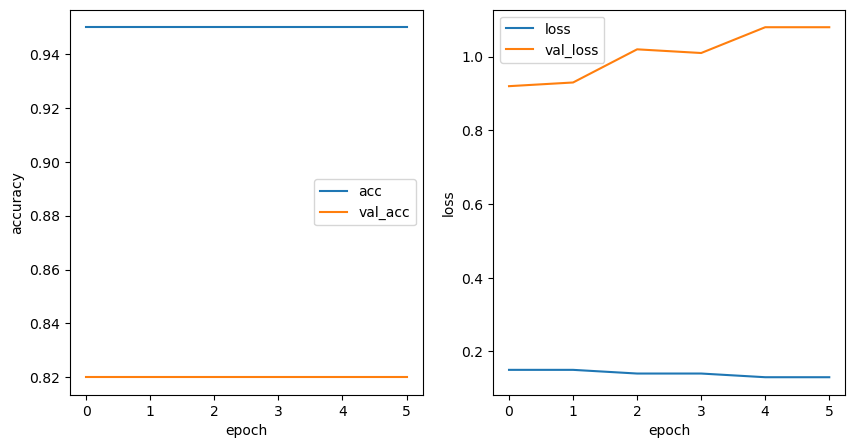

In [47]:
hm = modelm.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), callbacks=es, epochs=EPOCHS)
histm = pd.DataFrame(hm.history).round(2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.plot(histm.loss, label = "loss")
plt.plot(histm.val_loss, label = "val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,2,1)
plt.plot(histm.accuracy, label = "acc")
plt.plot(histm.val_accuracy, label = "val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.savefig('model2')

In [35]:
modelg = Sequential([
    Embedding(input_dim=10000, output_dim=4, input_length=50),
    Flatten(),
    Dense(64,activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(3, activation='softmax')
])

modelg.summary()
modelg.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hg = modelg.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), callbacks=es, epochs=EPOCHS)
histg = pd.DataFrame(hg.history).round(2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 4)             40000     
                                                                 
 flatten_6 (Flatten)         (None, 200)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                12864     
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 32)               

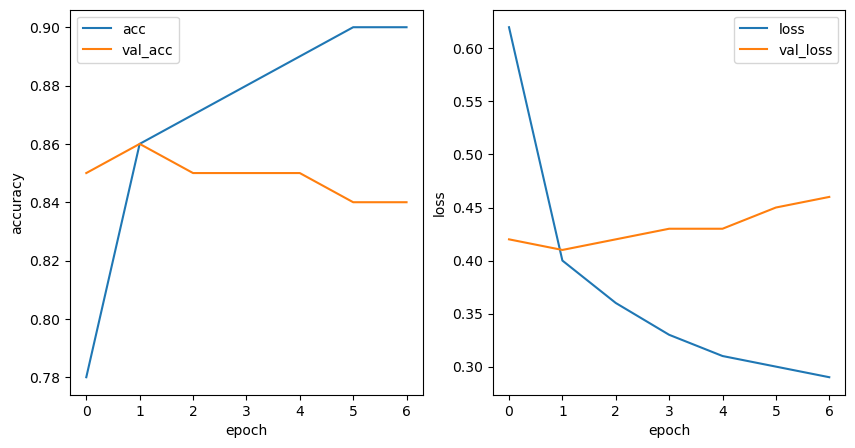

In [46]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(histg.accuracy, label = "acc")
plt.plot(histg.val_accuracy, label = "val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()


plt.subplot(1,2,2)
plt.plot(hist.loss, label = "loss")
plt.plot(histg.val_loss, label = "val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.savefig('model3')

In [39]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

In [42]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.regularizers import l2

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=3, input_length=50))
model.add(LSTM(100))
model.add(Dropout(0.5))  # Dodaj Dropout po LSTM
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  # Dodaj regularyzację L2
model.add(Dropout(0.5))  # Dodaj kolejny Dropout
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))  # Dodaj kolejną regularyzację L2
model.add(Dropout(0.5))  # Dodaj kolejny Dropout
model.add(Dense(3, activation='softmax'))

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

h = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), callbacks=es, epochs=EPOCHS)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 50, 3)             30000     
                                                                 
 lstm_14 (LSTM)              (None, 100)               41600     
                                                                 
 dropout_27 (Dropout)        (None, 100)               0         
                                                                 
 dense_30 (Dense)            (None, 64)                6464      
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 dropout_29 (Dropout)        (None, 32)              

2024-01-31 20:26:47.758402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-31 20:26:47.759904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-31 20:26:47.760860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/opt/tljh/user/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/tljh/user/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/tljh/user/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/tljh/user/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/tljh/user/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/opt/tljh/user/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/tljh/user/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/opt/tljh/user/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/opt/tljh/user/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/tljh/user/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/tljh/user/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/tljh/user/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/tljh/user/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/tljh/user/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/tljh/user/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/tljh/user/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/tljh/user/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/tljh/user/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/tljh/user/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/tljh/user/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/tljh/user/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2986402/175673879.py", line 18, in <module>
      h = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), callbacks=es, epochs=EPOCHS)
    File "/opt/tljh/user/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/tljh/user/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/tljh/user/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/opt/tljh/user/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/tljh/user/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/tljh/user/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/tljh/user/lib/python3.9/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/opt/tljh/user/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/tljh/user/lib/python3.9/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/tljh/user/lib/python3.9/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/tljh/user/lib/python3.9/site-packages/keras/losses.py", line 2078, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/opt/tljh/user/lib/python3.9/site-packages/keras/backend.py", line 5660, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [32,3] and labels shape [96]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_907199]

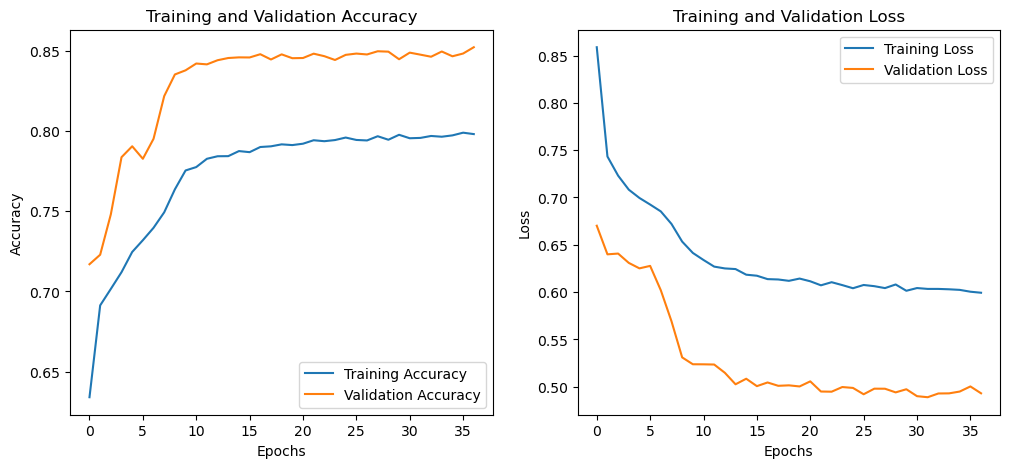

In [45]:
import matplotlib.pyplot as plt

# Assuming 'h' is the history object returned by the 'fit' method of your model
history = h.history

# Plotting training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('model4')
plt.show()

In [21]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1, input_length=50, output_dim=100))
# Usunięto Flatten przed LSTM
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
h = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), callbacks=[es], epochs=EPOCHS)



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 100)           8143700   
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               12928     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 3)                 387       
                                                                 
Total params: 8,237,415
Trainable params: 8,237,415
No

2024-01-31 19:41:47.988292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-31 19:41:47.989367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-31 19:41:47.990682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4075/4075 [==============================] - ETA: 0s - loss: 1.0760 - accuracy: 0.4473

2024-01-31 19:42:56.759148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-31 19:42:56.760708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-31 19:42:56.761687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4075/4075 [==============================] - 74s 18ms/step - loss: 1.0760 - accuracy: 0.4473 - val_loss: 1.0668 - val_accuracy: 0.4428
Epoch 2/100
4075/4075 [==============================] - 54s 13ms/step - loss: 1.0621 - accuracy: 0.4450 - val_loss: 1.0584 - val_accuracy: 0.4425
Epoch 3/100
4075/4075 [==============================] - 53s 13ms/step - loss: 1.0600 - accuracy: 0.4435 - val_loss: 1.0581 - val_accuracy: 0.4425
Epoch 4/100
4075/4075 [==============================] - 52s 13ms/step - loss: 1.0598 - accuracy: 0.4435 - val_loss: 1.0579 - val_accuracy: 0.4425
Epoch 5/100
4075/4075 [==============================] - 51s 13ms/step - loss: 1.0598 - accuracy: 0.4435 - val_loss: 1.0579 - val_accuracy: 0.4425
Epoch 6/100
4075/4075 [==============================] - 52s 13ms/step - loss: 1.0597 - accuracy: 0.4435 - val_loss: 1.0580 - val_accuracy: 0.4425
Epoch 7/100
4075/4075 [==============================] - 52s 13ms/step - loss: 1.0598 - accuracy: 0.4435 - val_loss: 1.0579 - val_

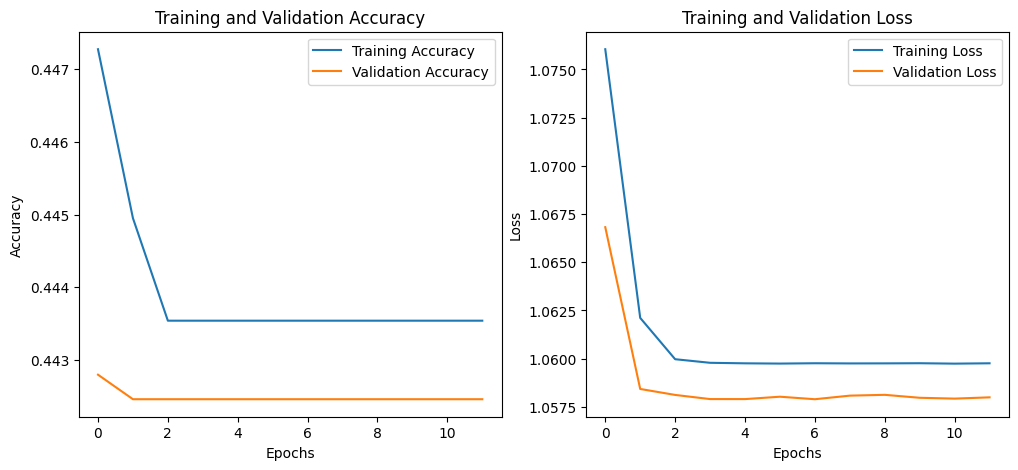

In [29]:
# Assuming 'h' is the history object returned by the 'fit' method of your model
history = h.history

# Plotting training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('model5')
plt.show()